<a href="https://colab.research.google.com/github/V1ncenttt/FetalSeg/blob/main/FetalSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetal head segmentation
## With a U-net
Dataset from https://www.kaggle.com/datasets/ankit8467/fetal-head-ultrasound-dataset-for-image-segment?resource=download

In [ ]:
!pip install pyunpack

In [ ]:
from google.colab import drive
from pyunpack import Archive
import shutil
import os
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import pandas as pd
import numpy as np
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

In [ ]:
Archive('/content/drive/MyDrive/segmentation.zip').extractall('/content/seg_data')


In [ ]:
%cd seg_data

/content/seg_data


In [ ]:
!mkdir training_images
!mkdir annotated_training_images

In [ ]:
%cd /content/seg_data/training_set/
for filename in os.listdir():
  if filename.endswith(".png") or filename.endswith(".jpg"):
    if "Annotation" in filename:
      shutil.copy(filename, '/content/seg_data/annotated_training_images')
    else:
      shutil.copy(filename, '/content/seg_data/training_images')


/content/seg_data/training_set


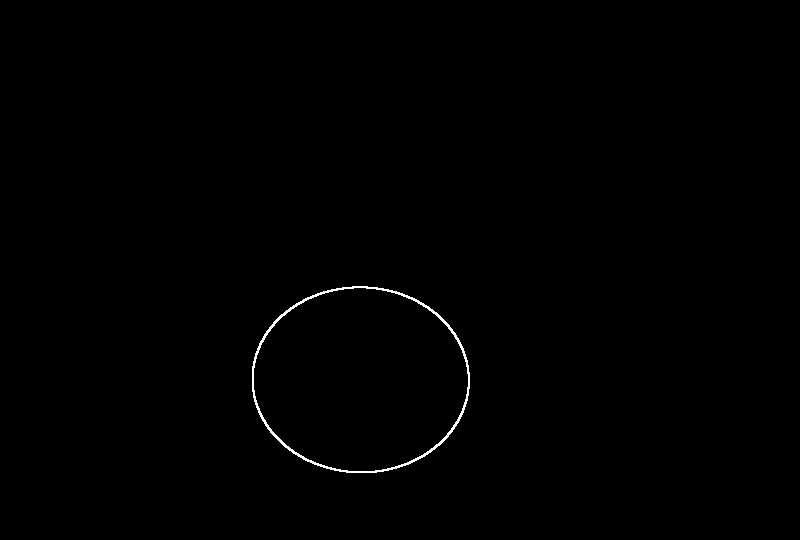

 <class 'numpy.ndarray'>


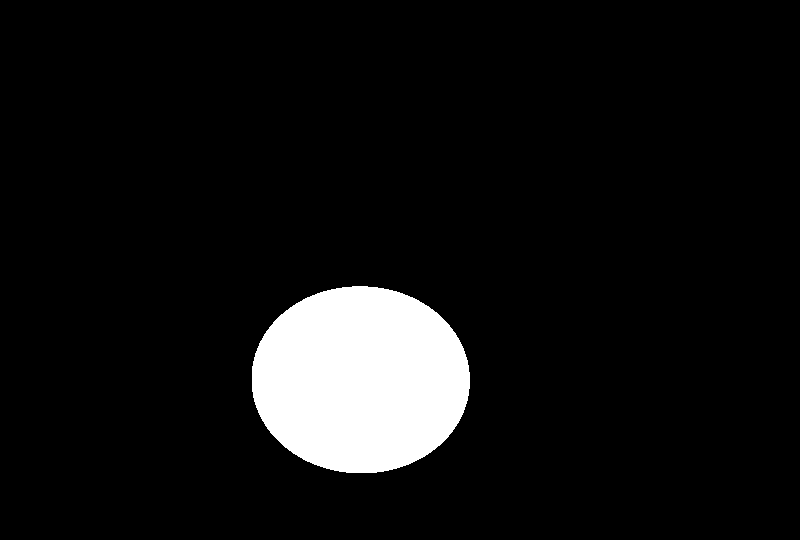

 <class 'numpy.ndarray'>


In [ ]:
mask1 = cv2.imread('/content/seg_data/annotated_training_images/100_2HC_Annotation.png', 0)
mask = cv2.imread('/content/seg_data/annotated_training_images/100_2HC_Annotation.png', 0)
mask_contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_img = cv2.drawContours(mask, mask_contour[0], 0, 255, -1)
cv2_imshow(mask1)
print("", type(mask1))
cv2_imshow(mask_img)
print("", type(mask_img))


## Padding images to make them square

torch.Size([1, 812, 812])


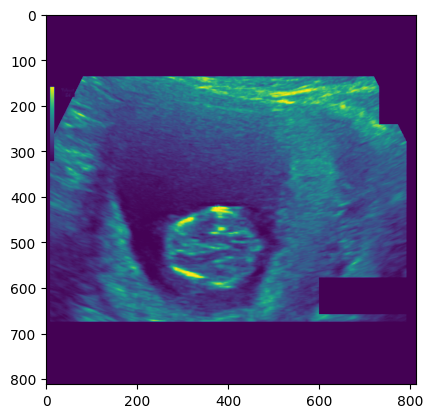

In [ ]:
def to_square(img, target_size=812):
    channels, height, width = img.size()

    # Pad width to target size
    if width < target_size:
        width_diff = target_size - width
        left_padding = width_diff // 2
        right_padding = width_diff - left_padding
        img = torch.nn.functional.pad(img, (left_padding, right_padding, 0, 0), mode='constant', value=0)

    channels, height, width = img.size()

    # Pad height to match width if needed
    if height < width:
        height_diff = width - height
        top_padding = height_diff // 2
        bottom_padding = height_diff - top_padding
        padded_image = torch.nn.functional.pad(img, (0, 0, top_padding, bottom_padding), mode='constant', value=0)
    else:
        padded_image = img

    return padded_image

img = read_image('/content/seg_data/training_images/100_2HC.png')

padded_img = to_square(img)
print(padded_img.size())
plt.imshow(padded_img.permute(1,2,0))
plt.show()


Here we create the dataset.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform , target_transform):
        self.img_path = img_path
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img = to_square(img)

        if self.target_path:
          img_path_tar = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])

          target = cv2.imread(img_path_tar , 0)
          mask_contour= cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(target,mask_contour[0],0,255, -1)
          target = target[np.newaxis, :, :]
          target = torch.from_numpy(target)
          target = to_square(target)
        else :
          target = torch.tensor([])


        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            # print("target", target.shape, type(target))
            target = self.target_transform(target)
            target = torch.where(target > 128, torch.tensor([1.0]), torch.tensor([0.0]))

        return img.float(), target.float()



# Define the transformation to resize the images to 64x64 pixels
transform = transforms.Compose([
    transforms.Resize((252, 252))   # 572 , 572
    # transforms.ToTensor()
])

transform1 = transforms.Compose([
    transforms.Resize((68, 68))   # 388 , 388'

])
# Instantiate dataset object
dataset = CustomDataset(

    img_path = '/content/seg_data/training_images/' ,
    target_path = '/content/seg_data/annotated_training_images/' ,
    transform=transform ,
    target_transform = transform1 )

test_dataset = CustomDataset(
    img_path = '/content/seg_data/test_set/' ,
    target_path = None ,
    transform=transform ,
    target_transform = None
    )

# justto check number of images
img_path = '/content/seg_data/training_images/'
print(len(os.listdir(img_path)))
target_path = '/content/seg_data/annotated_training_images/'
print(len(os.listdir(target_path)))


import torch.utils.data as data
train_dataset, val_dataset = data.random_split(dataset, [799, 200])


# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True) #,worker_init_fn=lambda _: random.seed(42))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))


999
999


Then we show some sample scans...

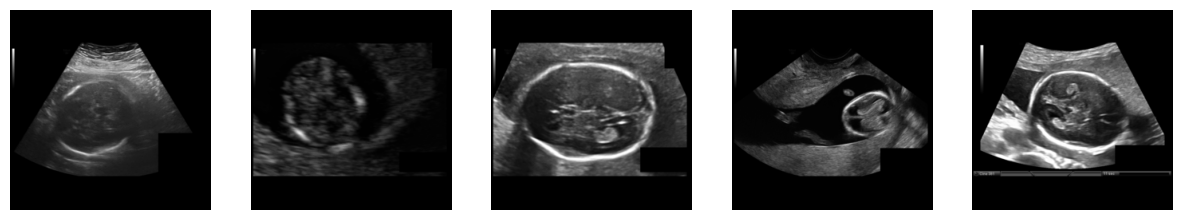

In [ ]:
i = 0

for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(5):
      axs[i].imshow(batch[0][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

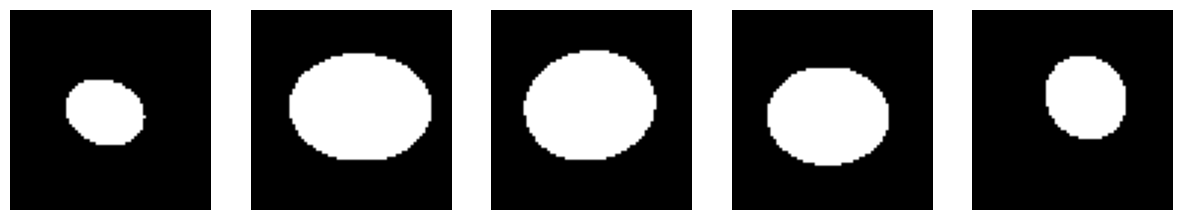

In [ ]:
i = 0

for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(5):
      axs[i].imshow(batch[1][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1



## Create the U-Net

In [ ]:
def scale_tensor(image ,new_height , new_width):
  scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
  return scaled_image


#double 3x3 convolution
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size
# as shown in architecture image , half left side image is concated with right side image
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

def out_layer(in_channel , out_channel):
  conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1),
      nn.BatchNorm2d(out_channel),
      nn.Sigmoid()
  )
  return conv_layer

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        # Left side (contracting path)
        self.dwn_conv1 = dual_conv(1, 64)
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128, 256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Right side  (expnsion path)
        #transpose convolution is used showna as green arrow in architecture image
        self.conv_bn=nn.BatchNorm2d(1024)

        self.trans1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride= 2)
        self.up_conv1 = dual_conv(1024,512)
        self.trans2 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv2 = dual_conv(512,256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride= 2)
        self.up_conv3 = dual_conv(256,128)
        self.trans4 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv4 = dual_conv(128,64)

        #output layer
        # self.out = nn.Conv2d(64, 1, kernel_size=1)
        self.out = out_layer(64 , 1)

    def forward(self, image):

        #Padding the image to make it sqare
        # image = pad_image_to_square(image)
        #forward pass for Left side

        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)


        #forward pass for Right side
        x_norm = self.conv_bn(x9)
        x = self.trans1(x_norm)
        y = crop_tensor(x, x7)
        # print(x.shape , y.shape)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,y], 1))

        x = self.out(x)


        return x




In [ ]:
# Enable GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Training

In [ ]:
# from dataset import MyDataset
# from model import UNet

torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
# batch_size = 2
learning_rate = 0.01
num_epochs = 30



# Define the U-Net architecture
model = Unet()
if torch.cuda.is_available():
  model.cuda()

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

v_loss , train_loss = [] , []
# Train the U-Net
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = 0
    for inputs, targets in val_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets)
    val_loss /= len(val_dataloader)
  v_loss.append(val_loss.item())
  train_loss.append(loss.item())
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")

# Save the trained model
# torch.save(model.state_dict(), 'path/to/trained/model')



## Validation performance

In [ ]:
def dice_coefficient(y_pred, y_true):
    smooth = 0.001
    y_pred = y_pred.view(-1)
    # print(type(y_pred), y_pred.shape)
    y_true = y_true.view(-1)
    intersection = torch.sum(y_pred * y_true)
    dice = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
    return dice

def dice_score(y_pred_batch, y_true_batch):
    dice_scores = torch.zeros(y_pred_batch.shape[0])
    for i in range(y_pred_batch.shape[0]):
        dice_scores[i] = dice_coefficient(y_pred_batch[i], y_true_batch[i])
    return dice_scores

with torch.no_grad():
  dice_com = torch.tensor([])
  model.to(device)
  model.eval()
  val_loss = 0
  for inputs, targets in val_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)#

      outputs = model(inputs)
      outputs = torch.where(outputs > 0.5, torch.tensor([1.0]).to(device), torch.tensor([0.0]).to(device))
      dice = dice_score(outputs, targets)
      dice_com = torch.cat((dice_com, dice))

print("Dice Score of Validation Set")
dice_com.mean().item()

Dice Score of Validation Set


0.891042947769165

Text(0, 0.5, 'loss')

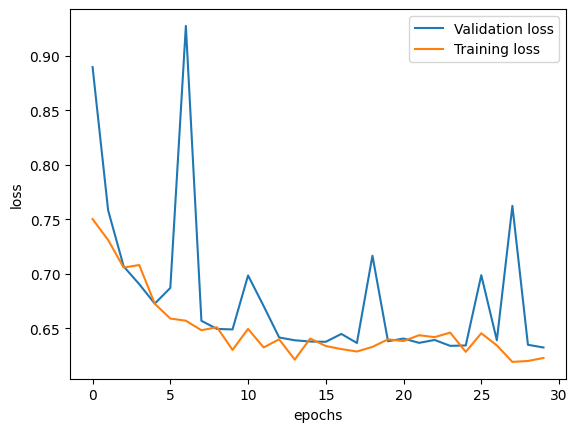

In [ ]:
plt.plot(v_loss)
plt.plot(train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/model1.pt')
# model.load_state_dict(torch.load(model_path))


In [ ]:
torch.cuda.empty_cache()
# del model
import gc
gc.collect()

35

In [ ]:

# Get the first 2 batches
top_2_batches = list(itertools.islice(test_dataloader, 2))

out = []
test = []
test1 = []
# Process the batches
with torch.no_grad():
  for batch in top_2_batches:
      # Do something with the batch

      inputs = batch[0].to(device)   #

      test.append(inputs)
      test1.append(batch[1].to(device))

      outputs = model(inputs)
      out.append(outputs)

      torch.cuda.empty_cache()
      gc.collect()
      print(batch[0].shape)

torch.Size([16, 1, 252, 252])
torch.Size([16, 1, 252, 252])


In [ ]:
# Create a tensor of size [5, 1, 628, 628] (replace with your own tensor)
tensor = out[0].cpu().detach().numpy()

# Plot each image in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

NameError: name 'out' is not defined

## Testing the model

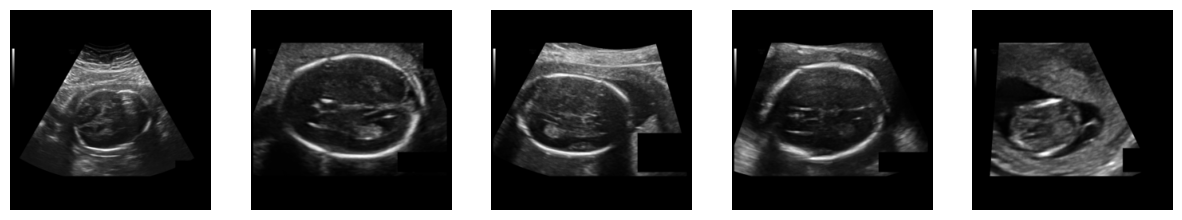

In [ ]:
# Create a tensor of size [5, 1, 628, 628] (replace with your own tensor)
tensor_train = test[0].cpu().detach().numpy()

# Plot each image in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor_train[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()